In [1]:
import torch
import torch.nn as nn
import torchvision.datasets
import h5py
import zipfile
import imageio
import os
import numpy
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import random
import pandas

import time
import cv2
#mport pandas, numpy, random

In [2]:
# check if CUDA is available
# if yes, set default tensor type to cuda

if torch.cuda.is_available():
  torch.set_default_tensor_type(torch.cuda.FloatTensor)
  print("using cuda:", torch.cuda.get_device_name(0))
  pass

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

using cuda: GeForce RTX 3080


device(type='cuda')

In [3]:
# functions to generate random data

def generate_random_image(size):
    random_data = torch.rand(size)
    return random_data


def generate_random_seed(size):
    random_data = torch.randn(size)
    return random_data

In [4]:
# modified from https://github.com/pytorch/vision/issues/720

class View(nn.Module):
    def __init__(self, shape):
        super().__init__()
        self.shape = shape,

    def forward(self, x):
        return x.view(*self.shape)

In [5]:
# crop (numpy array) image to given width and height

def crop_centre(img, new_width, new_height):
    height, width, _ = img.shape
    startx = width//2 - new_width//2
    starty = height//2 - new_height//2    
    return img[  starty:starty + new_height, startx:startx + new_width, :]

In [6]:
# dataset class

class CelebADataset(Dataset):
    
    def __init__(self, file):
        self.file_object = h5py.File(file, 'r')
        self.dataset = self.file_object['img_align_celeba']
        pass
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, index):
        if (index >= len(self.dataset)):
          raise IndexError()
        img = numpy.array(self.dataset[str(index)+'.jpg'])
        # crop to 128x128 square
        img = crop_centre(img, 128, 128)
        return torch.cuda.FloatTensor(img).permute(2,0,1).view(1,3,128,128) / 255.0
    
    def plot_image(self, index):
        img = numpy.array(self.dataset[str(index)+'.jpg'])
        # crop to 128x128 square
        img = crop_centre(img, 128, 128)
        plt.imshow(img, interpolation='nearest')
        pass
    
    pass

In [7]:
# create Dataset object

celeba_dataset = CelebADataset('./celeba_dataset/celeba_aligned_small.h5py')

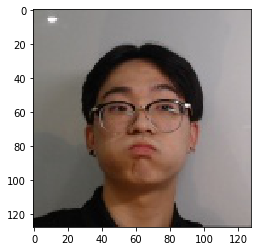

In [8]:
# check data contains images

celeba_dataset.plot_image(1000)

In [9]:
class Discriminator(nn.Module):
    
    def __init__(self):
        # initialise parent pytorch class
        super().__init__()
        
        # define neural network layers
        self.model = nn.Sequential(
            # expect input of shape (1,3,128,128)
            nn.Conv2d(3, 256, kernel_size=8, stride=2),
            nn.BatchNorm2d(256),
            #nn.LeakyReLU(0.2),
            nn.GELU(),
            
            nn.Conv2d(256, 256, kernel_size=8, stride=2),
            nn.BatchNorm2d(256),
            #nn.LeakyReLU(0.2),
            nn.GELU(),
            
            nn.Conv2d(256, 3, kernel_size=8, stride=2),
            #nn.LeakyReLU(0.2),
            nn.GELU(),
            
            View(3*10*10),
            nn.Linear(3*10*10, 1),
            nn.Sigmoid()
        )
        
        # create loss function
        self.loss_function = nn.BCELoss()

        # create optimiser, simple stochastic gradient descent
        self.optimiser = torch.optim.Adam(self.parameters(), lr=0.0001)

        # counter and accumulator for progress
        self.counter = 0;
        self.progress = []

        pass
    
    
    def forward(self, inputs):
        # simply run model
        return self.model(inputs)
    
    
    def train(self, inputs, targets):
        # calculate the output of the network
        outputs = self.forward(inputs)
        
        # calculate loss
        loss = self.loss_function(outputs, targets)

        # increase counter and accumulate error every 10
        self.counter += 1;
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass
        if (self.counter % 30000 == 0):
            #print("counter = ", self.counter)
            pass

        # zero gradients, perform a backward pass, update weights
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

        pass
    
    
    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0))
        pass
    
    pass

In [ ]:
%%time
# test discriminator can separate real data from random noise

D = Discriminator()
# move model to cuda device
D.to(device)

for image_data_tensor in celeba_dataset:
    # real data
    D.train(image_data_tensor, torch.cuda.FloatTensor([1.0]))
    # fake data
    D.train(generate_random_image((1,3,128,128)), torch.cuda.FloatTensor([0.0]))
    pass

In [ ]:
# plot discriminator loss

D.plot_progress()

In [ ]:
# manually run discriminator to check it can tell real data from fake

for i in range(4):
  image_data_tensor = celeba_dataset[random.randint(0,20000)]
  print( D.forward( image_data_tensor ).item() )
  pass

for i in range(4):
  print( D.forward( generate_random_image((1,3,128,128))).item() )
  pass

In [28]:
# generator class

class Generator(nn.Module):
    
    def __init__(self):
        # initialise parent pytorch class
        super().__init__()
        
        # define neural network layers
        self.model = nn.Sequential(
            # input is a 1d array
            nn.Linear(100, 3*11*11),
            #nn.LeakyReLU(0.2),
            nn.SiLU(),
            
            # reshape to 4d
            View((1, 3, 11, 11)),
            
            nn.ConvTranspose2d(3, 256, kernel_size=8, stride=2),
            nn.BatchNorm2d(256),
            #nn.LeakyReLU(0.2),
            nn.SiLU(),

            nn.ConvTranspose2d(256, 512, kernel_size=18, stride=1),
            nn.BatchNorm2d(512),
            #nn.LeakyReLU(0.2),
            nn.SiLU(),
            
            nn.ConvTranspose2d(512, 256, kernel_size=18, stride=1),
            nn.BatchNorm2d(256),
            #nn.LeakyReLU(0.2),
            nn.SiLU(),
            
            nn.ConvTranspose2d(256, 3, kernel_size=8, stride=2, padding=1),
            nn.BatchNorm2d(3),
            
            # output should be (1,3,128,128)
            nn.Sigmoid()
        )
        
        # create optimiser, simple stochastic gradient descent
        self.optimiser = torch.optim.Adam(self.parameters(), lr=0.0001)

        # counter and accumulator for progress
        self.counter = 0;
        self.progress = []
        
        pass
    
    
    def forward(self, inputs):        
        # simply run model
        return self.model(inputs)
    
    
    def train(self, D, inputs, targets):
        # calculate the output of the network
        g_output = self.forward(inputs)
        
        # pass onto Discriminator
        d_output = D.forward(g_output)
        
        # calculate error
        loss = D.loss_function(d_output, targets)

        # increase counter and accumulate error every 10
        self.counter += 1;
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass

        # zero gradients, perform a backward pass, update weights
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

        pass
    
    
    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0))
        pass
    
    pass

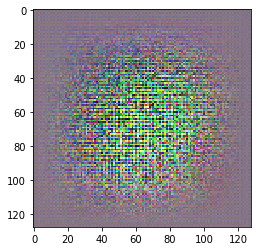

In [30]:
# check the generator output is of the right type and shape

G = Generator()
# move model to cuda device
G.to(device)

output = G.forward(generate_random_seed(100))

img = output.detach().permute(0,2,3,1).view(128,128,3).cpu().numpy()

plt.imshow(img, interpolation='none', cmap='Blues')

In [31]:
D = Discriminator()
G = Generator() 
D.to(device)
G.to(device)

Generator(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=363, bias=True)
    (1): SiLU()
    (2): View()
    (3): ConvTranspose2d(3, 256, kernel_size=(8, 8), stride=(2, 2))
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): SiLU()
    (6): ConvTranspose2d(256, 512, kernel_size=(18, 18), stride=(1, 1))
    (7): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): SiLU()
    (9): ConvTranspose2d(512, 256, kernel_size=(18, 18), stride=(1, 1))
    (10): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): SiLU()
    (12): ConvTranspose2d(256, 3, kernel_size=(8, 8), stride=(2, 2), padding=(1, 1))
    (13): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): Sigmoid()
  )
)

In [32]:
# train Discriminator and Generator

epochs = 20

a = time.time()

for epoch in range(epochs):
    print ("epoch = ", epoch + 1)

    # train Discriminator and Generator
  
    for image_data_tensor in celeba_dataset:
        # train discriminator on true
        D.train(image_data_tensor, torch.cuda.FloatTensor([1.0]))
    
        # train discriminator on false
        # use detach() so gradients in G are not calculated
        D.train(G.forward(generate_random_seed(100)).detach(), torch.cuda.FloatTensor([0.0]))
    
        # train generator
        G.train(D, generate_random_seed(100), torch.cuda.FloatTensor([1.0]))    

    #  Util Visualizaing
    output = G.forward(generate_random_seed(100))
    img = output.detach().permute(0,2,3,1).view(128,128,3).cpu().numpy()
    cv2.imwrite("v7_vis/face_" + str(epoch+1) + ".jpg", cv2.cvtColor(img*255, cv2.COLOR_BGR2RGB))
    
b = time.time()

print(b-a)

epoch =  1
epoch =  2
epoch =  3
epoch =  4
epoch =  5
epoch =  6
epoch =  7
epoch =  8
epoch =  9
epoch =  10
epoch =  11
epoch =  12
epoch =  13
epoch =  14
epoch =  15
epoch =  16
epoch =  17
epoch =  18
epoch =  19
epoch =  20
60731.16386079788


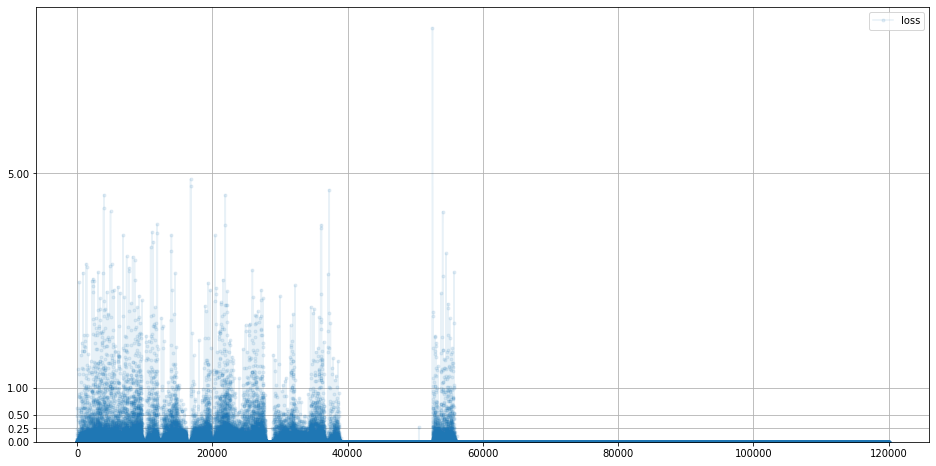

In [33]:
# plot discr

D.plot_progress()

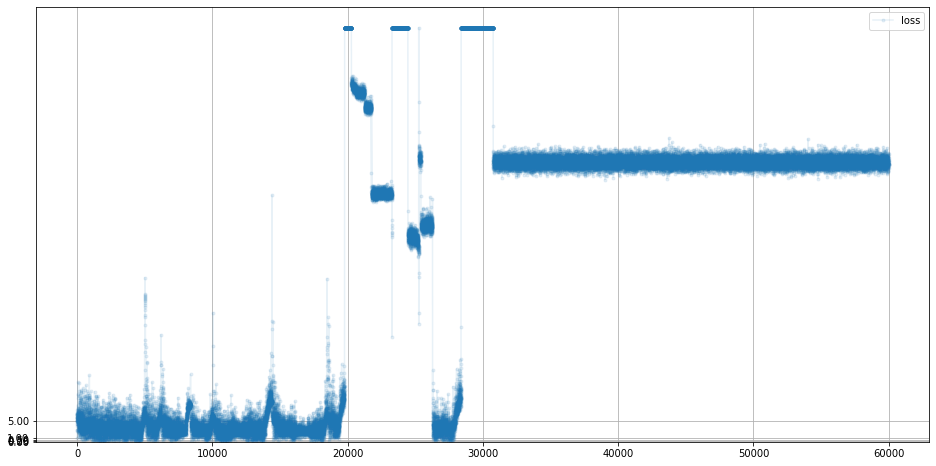

In [34]:
# plot generator error

G.plot_progress()

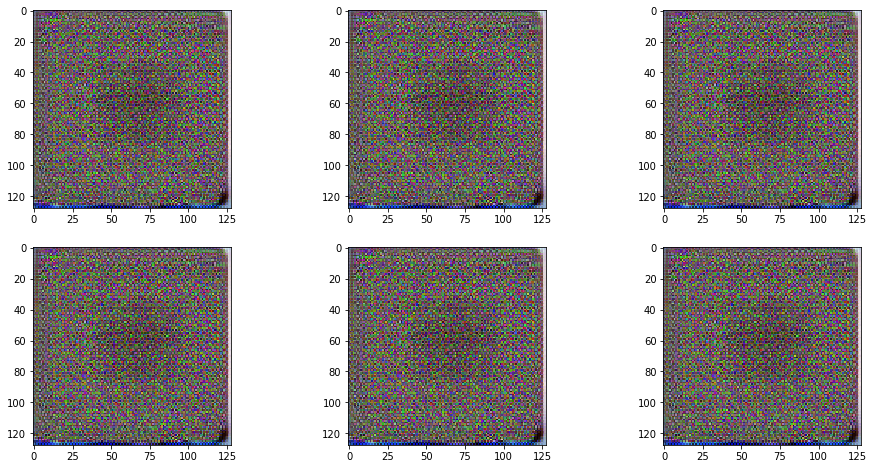

In [35]:
# plot several outputs from the trained generator

# plot a 3 column, 2 row array of generated images
f, axarr = plt.subplots(2,3, figsize=(16,8))
for i in range(2):
    for j in range(3):
        output = G.forward(generate_random_seed(100))
        img = output.detach().permute(0,2,3,1).view(128,128,3).cpu().numpy()
        axarr[i,j].imshow(img, interpolation='none', cmap='Blues')
        pass
    pass

In [36]:
# current memory allocated to tensors (in Gb)

torch.cuda.memory_allocated(device) / (1024*1024*1024)

1.3570904731750488

In [37]:
# total memory allocated to tensors during program (in Gb)

torch.cuda.max_memory_allocated(device) / (1024*1024*1024)

2.1604199409484863